# Advanced Regression Techniques - Ames, IA Housing Data

The purpose of this project is to determine the price of housing in the city of Ames, IA using real estate data and advanced regression models. The following are the libraries that will be used for the project:

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
from plotly.offline import plot, iplot
py.init_notebook_mode(connected=True)

import os
for dirname, _, filenames in os.walk('/git/AmesIARealEstate'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# import sklearn machine learning libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import math
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


RMSLE (Root Mean Square Log Error) must be used for this dataset to compare the predicted
data with the valid data. It's not a default scoring metric available
as a tool in scikit_learn. 

In [3]:
def root_mean_squared_log_error(y_valid, y_preds):
    #Calc rmse of log(y_test) and log(y_pred)
    
    if len(y_preds)!=len(y_valid): return 'error_mismatch'
    y_preds_new = [math.log(x) for x in y_preds]
    y_valid_new = [math.log(x) for x in y_valid]
    return mean_squared_error(y_valid_new,y_preds_new,squared=False)

# Data Loading and Analysis

In [4]:
# import the training dataset
df = pd.read_csv(r'C:\Users\pdudar\anaconda3\git\kaggle\input\train.csv')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:,.2f}".format
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Drop the Id column
df.drop('Id', axis=1, inplace=True)

# check the data structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
# Check for null data
df.isnull().sum()

# print out a list of attributes that have null data
print(df.columns[df.isna().any()].tolist())

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


19/80 attributes are missing values. These cells can be filled in with imputation
or other methods or deleted.

## Add average sale price column

In [7]:
# Create Average Sale Price column using GroupBy 
g = df.groupby('YearBuilt')['SalePrice'].mean().reset_index(name='AvgSalePrice')

# Merge the AvgSalePrice column with the original DataFrame on the YearBuilt column
df = pd.merge(df, g, on ='YearBuilt', how ="inner")

# Move YearBuilt column to first index position
df = df[['YearBuilt'] + [col for col in df.columns if col != 'YearBuilt']]

# Sort YearBuilt column in ascending order
df = df.sort_values(by='YearBuilt', ascending=True).reset_index(drop=True)
df

,YearBuilt,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AvgSalePrice
0,1872,70,RM,50.00,5250,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,8,5,1987,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,Gd,BrkTil,TA,Fa,No,LwQ,259,Unf,0,425,684,OthW,Fa,N,SBrkr,938,1215,205,2358,0,0,2,0,4,1,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,54,20,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,122000,"122,000.00"
1,1875,50,RL,54.00,6342,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,1Fam,1.5Fin,5,8,1996,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,780,780,GasA,Gd,N,SBrkr,780,240,0,1020,0,0,1,0,2,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,176,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,94000,"94,000.00"
2,1880,70,RM,90.00,9900,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,6,4,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.00,TA,TA,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1008,1008,GasW,TA,Y,SBrkr,1178,1032,0,2210,0,0,2,0,5,1,Fa,8,Typ,0,NaN,Detchd,"1,930.00",Unf,1,205,Fa,TA,N,0,48,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,117500,"200,619.75"
3,1880,75,RM,87.00,18386,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Fin,7,9,2002,Gable,CompShg,CemntBd,CmentBd,None,0.00,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,1470,1470,GasA,Ex,Y,SBrkr,1675,1818,0,3493,0,0,3,0,3,1,Gd,10,Typ,1,Ex,Attchd,"2,003.00",Unf,3,870,TA,TA,Y,302,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,295000,"200,619.75"
4,1880,70,RM,65.00,11700,Pave,Pave,IR1,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,7,2003,Mansard,CompShg,Stucco,Stucco,None,0.00,Gd,TA,Stone,TA,Fa,No,Unf,0,Unf,0,1240,1240,GasW,TA,N,SBrkr,1320,1320,0,2640,0,0,1,1,4,1,Gd,8,Typ,1,Gd,Detchd,"1,950.00",Unf,4,864,TA,TA,N,181,0,386,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979,"200,619.75"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2009,160,FV,30.00,3000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2009,Gable,CompShg,VinylSd,VinylSd,Stone,76.00,Gd,TA,PConc,Gd,TA,Av,GLQ,294,Unf,0,318,612,GasA,Ex,Y,SBrkr,612,612,0,1224,0,0,2,1,2,1,Gd,4,Typ,0,NaN,Detchd,"2,009.00",RFn,2,528,TA,TA,Y,0,234,0,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,173733,"269,220.00"
1456,2009,20,RL,83.00,10159,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2010,Hip,CompShg,VinylSd,VinylSd,Stone,450.00,Ex,TA,PConc,Ex,TA,Av,GLQ,1646,Unf,0,284,1930,GasA,Ex,Y,SBrkr,1940,0,0,1940,1,0,2,1,3,1,Ex,8,Typ,1,Gd,Attchd,"2,010.00",Fin,3,606,TA,TA,Y,168,95,0,0,0,0,NaN,NaN,NaN,0,4,2010,New,Partial,395192,"269,220.00"
1457,2009,20,RL,79.00,9541,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,7,5,2009,Gable,CompShg,VinylSd,VinylSd,Stone,268.00,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1502,1502,GasA,Ex,Y,SBrkr,1502,0,0,1502,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,"2,009.00",RFn,2,644,TA,TA,Y,0,114,0,0,0,0,NaN,NaN,NaN,0,9,2009,New,Partial,233170,"269,220.00"
1458,2009,20,FV,75.00,7862,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Some

## Create correlation heatmap charts

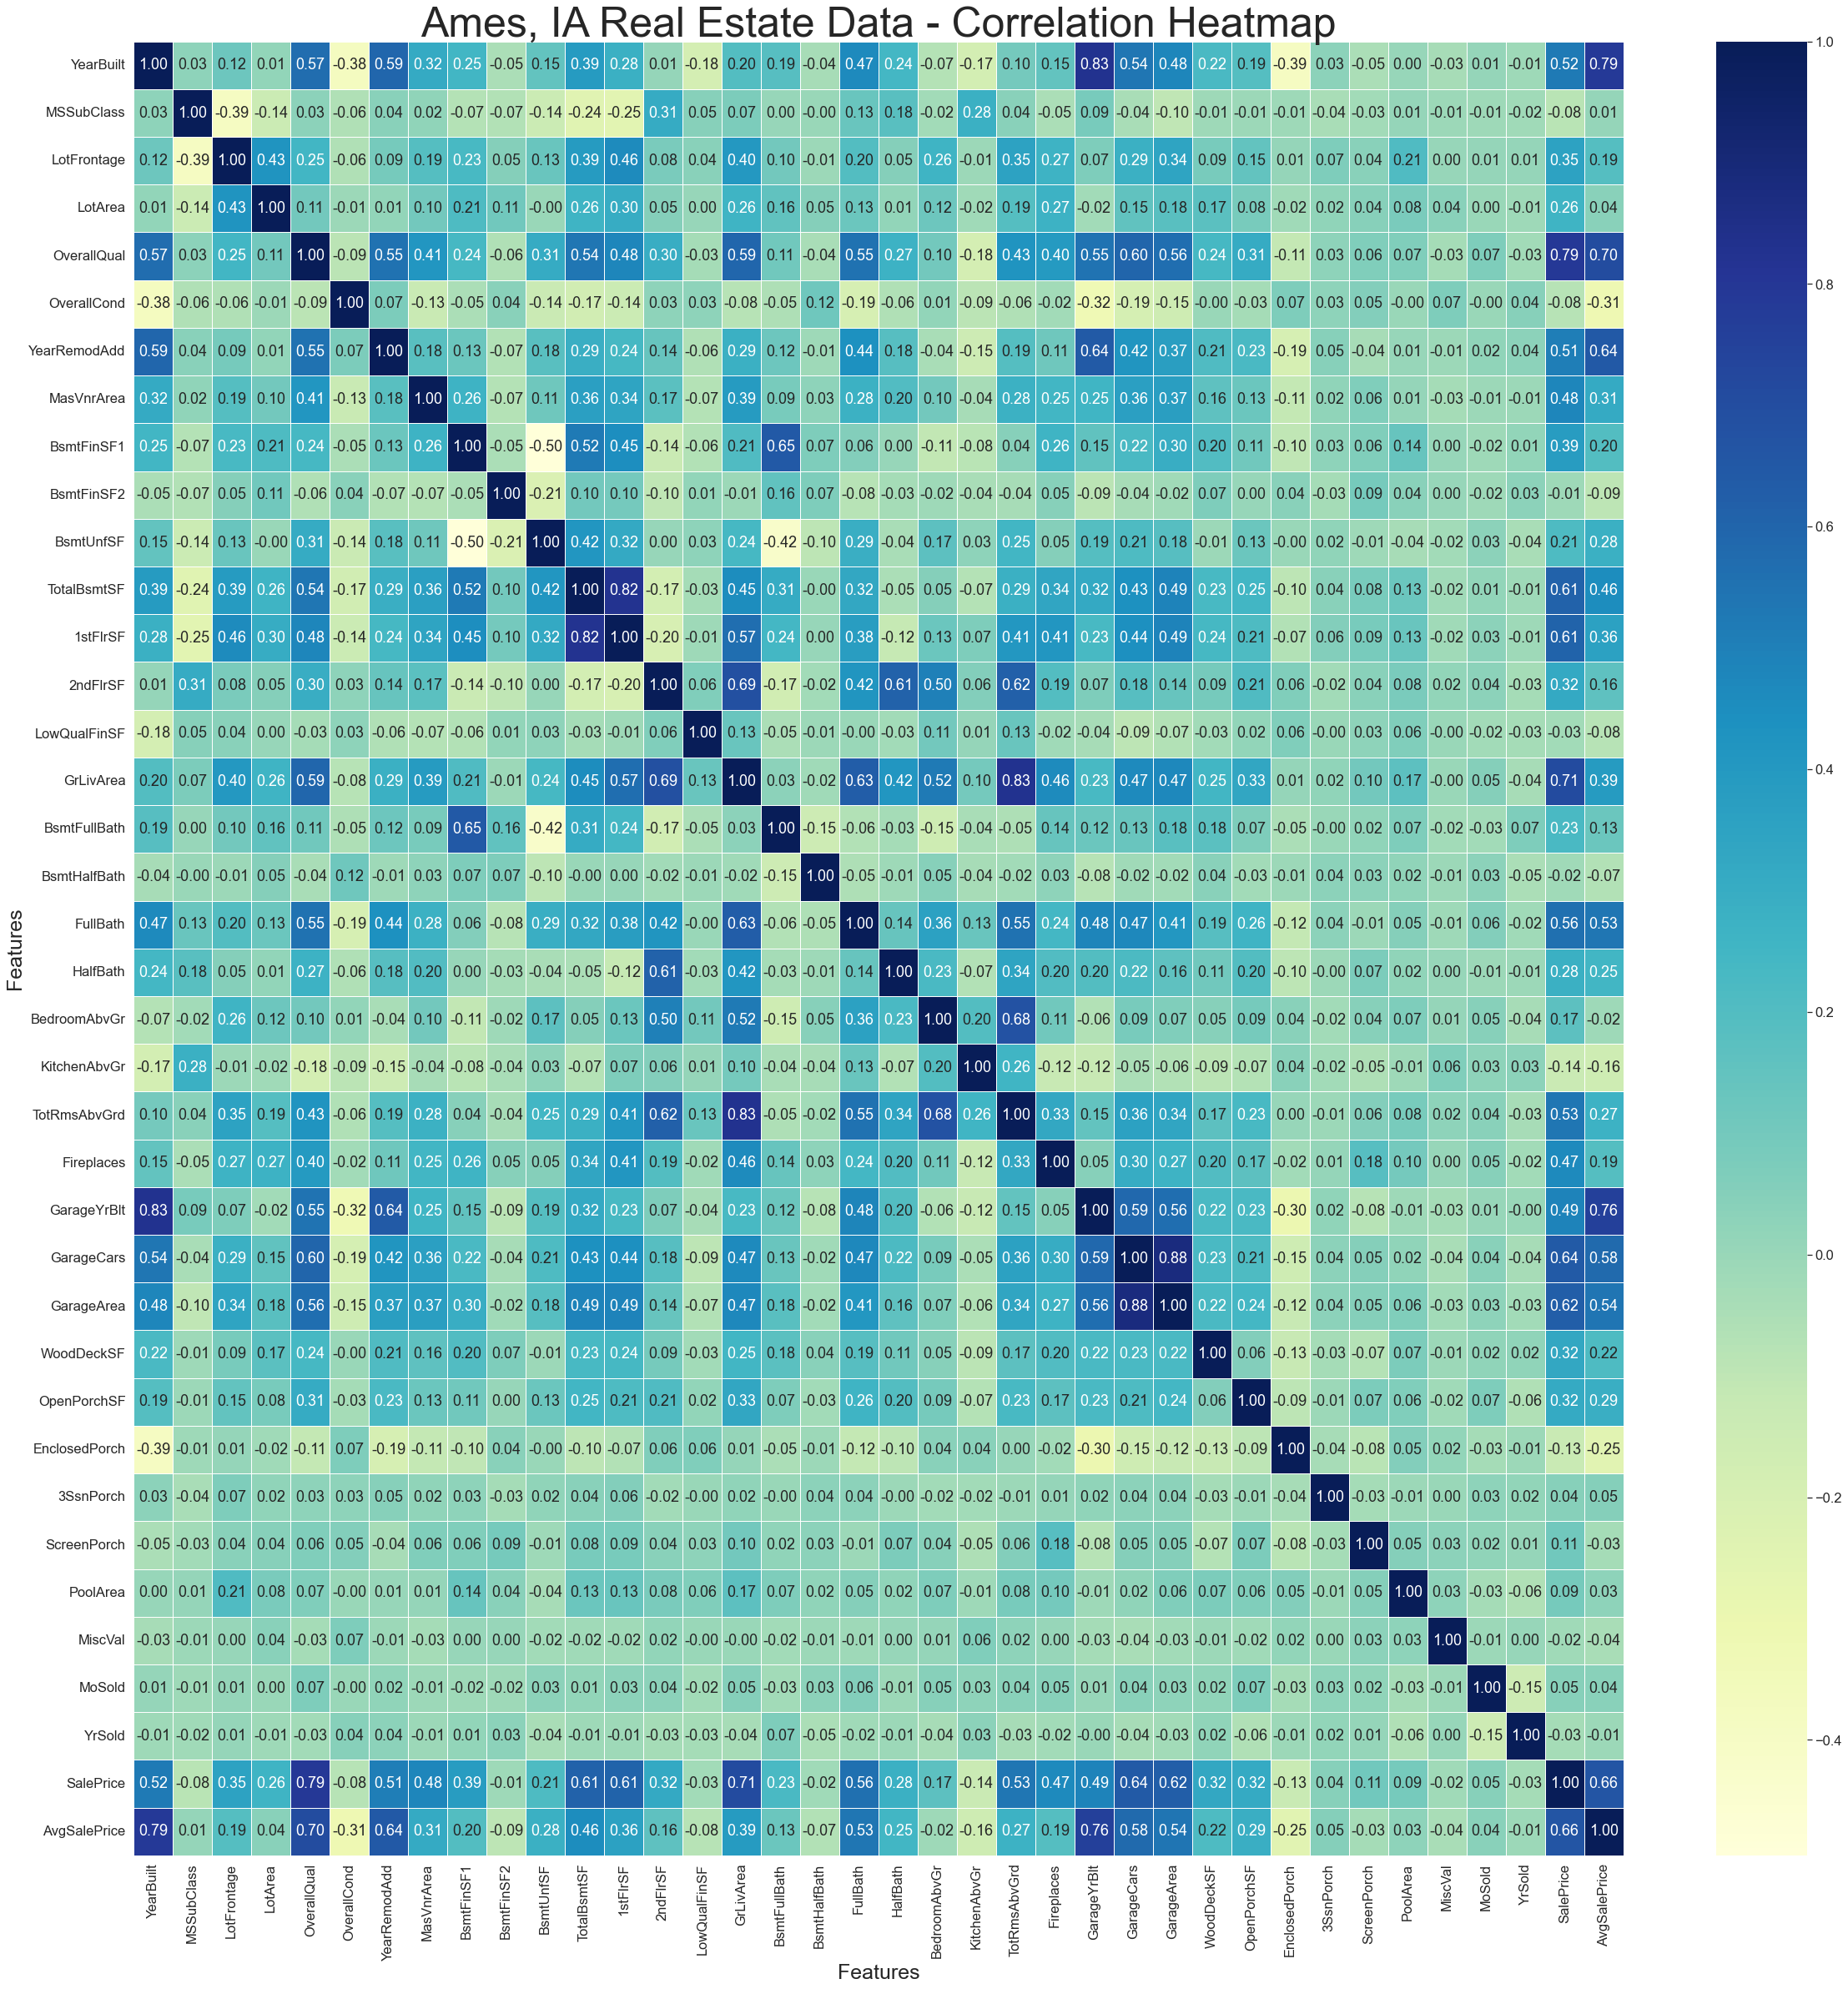

In [8]:
# Create Seaborn heat map and save as .png file
plt.rcParams['figure.figsize'] = 40,40
sns.set(font_scale=1.5)

ax = sns.heatmap(df.corr(),annot=True,fmt=".2f",cmap="YlGnBu",linewidths=0.5)
plt.title("Ames, IA Real Estate Data - Correlation Heatmap", fontsize=50)
plt.xlabel("Features", fontsize=25)
plt.ylabel("Features", fontsize=25)

plt.savefig('Ames_IA_RealEstateDataCorrelationHeatmap')
plt.show()

In [9]:
# Create Plotly interactive heatmap and save as .html file
corr = df.corr()

fig = go.Figure(data=go.Heatmap(
                   z=corr.values,
                   x=corr.index.values,
                   y=corr.columns.values,
                   hoverongaps = False)
)

fig.update_layout(
    title='Ames Real Estate Data - Correlation Heatmap')

fig.write_html('AmesRealEstateData_CorrelationHeatmap.html', include_plotlyjs='cdn')
fig.show()

What attributes are most important in determining SalePrice? Year of Renovations (YearRemodAdd), 
Age of House (YearBuilt), Square Footage etc. Let's investigate...

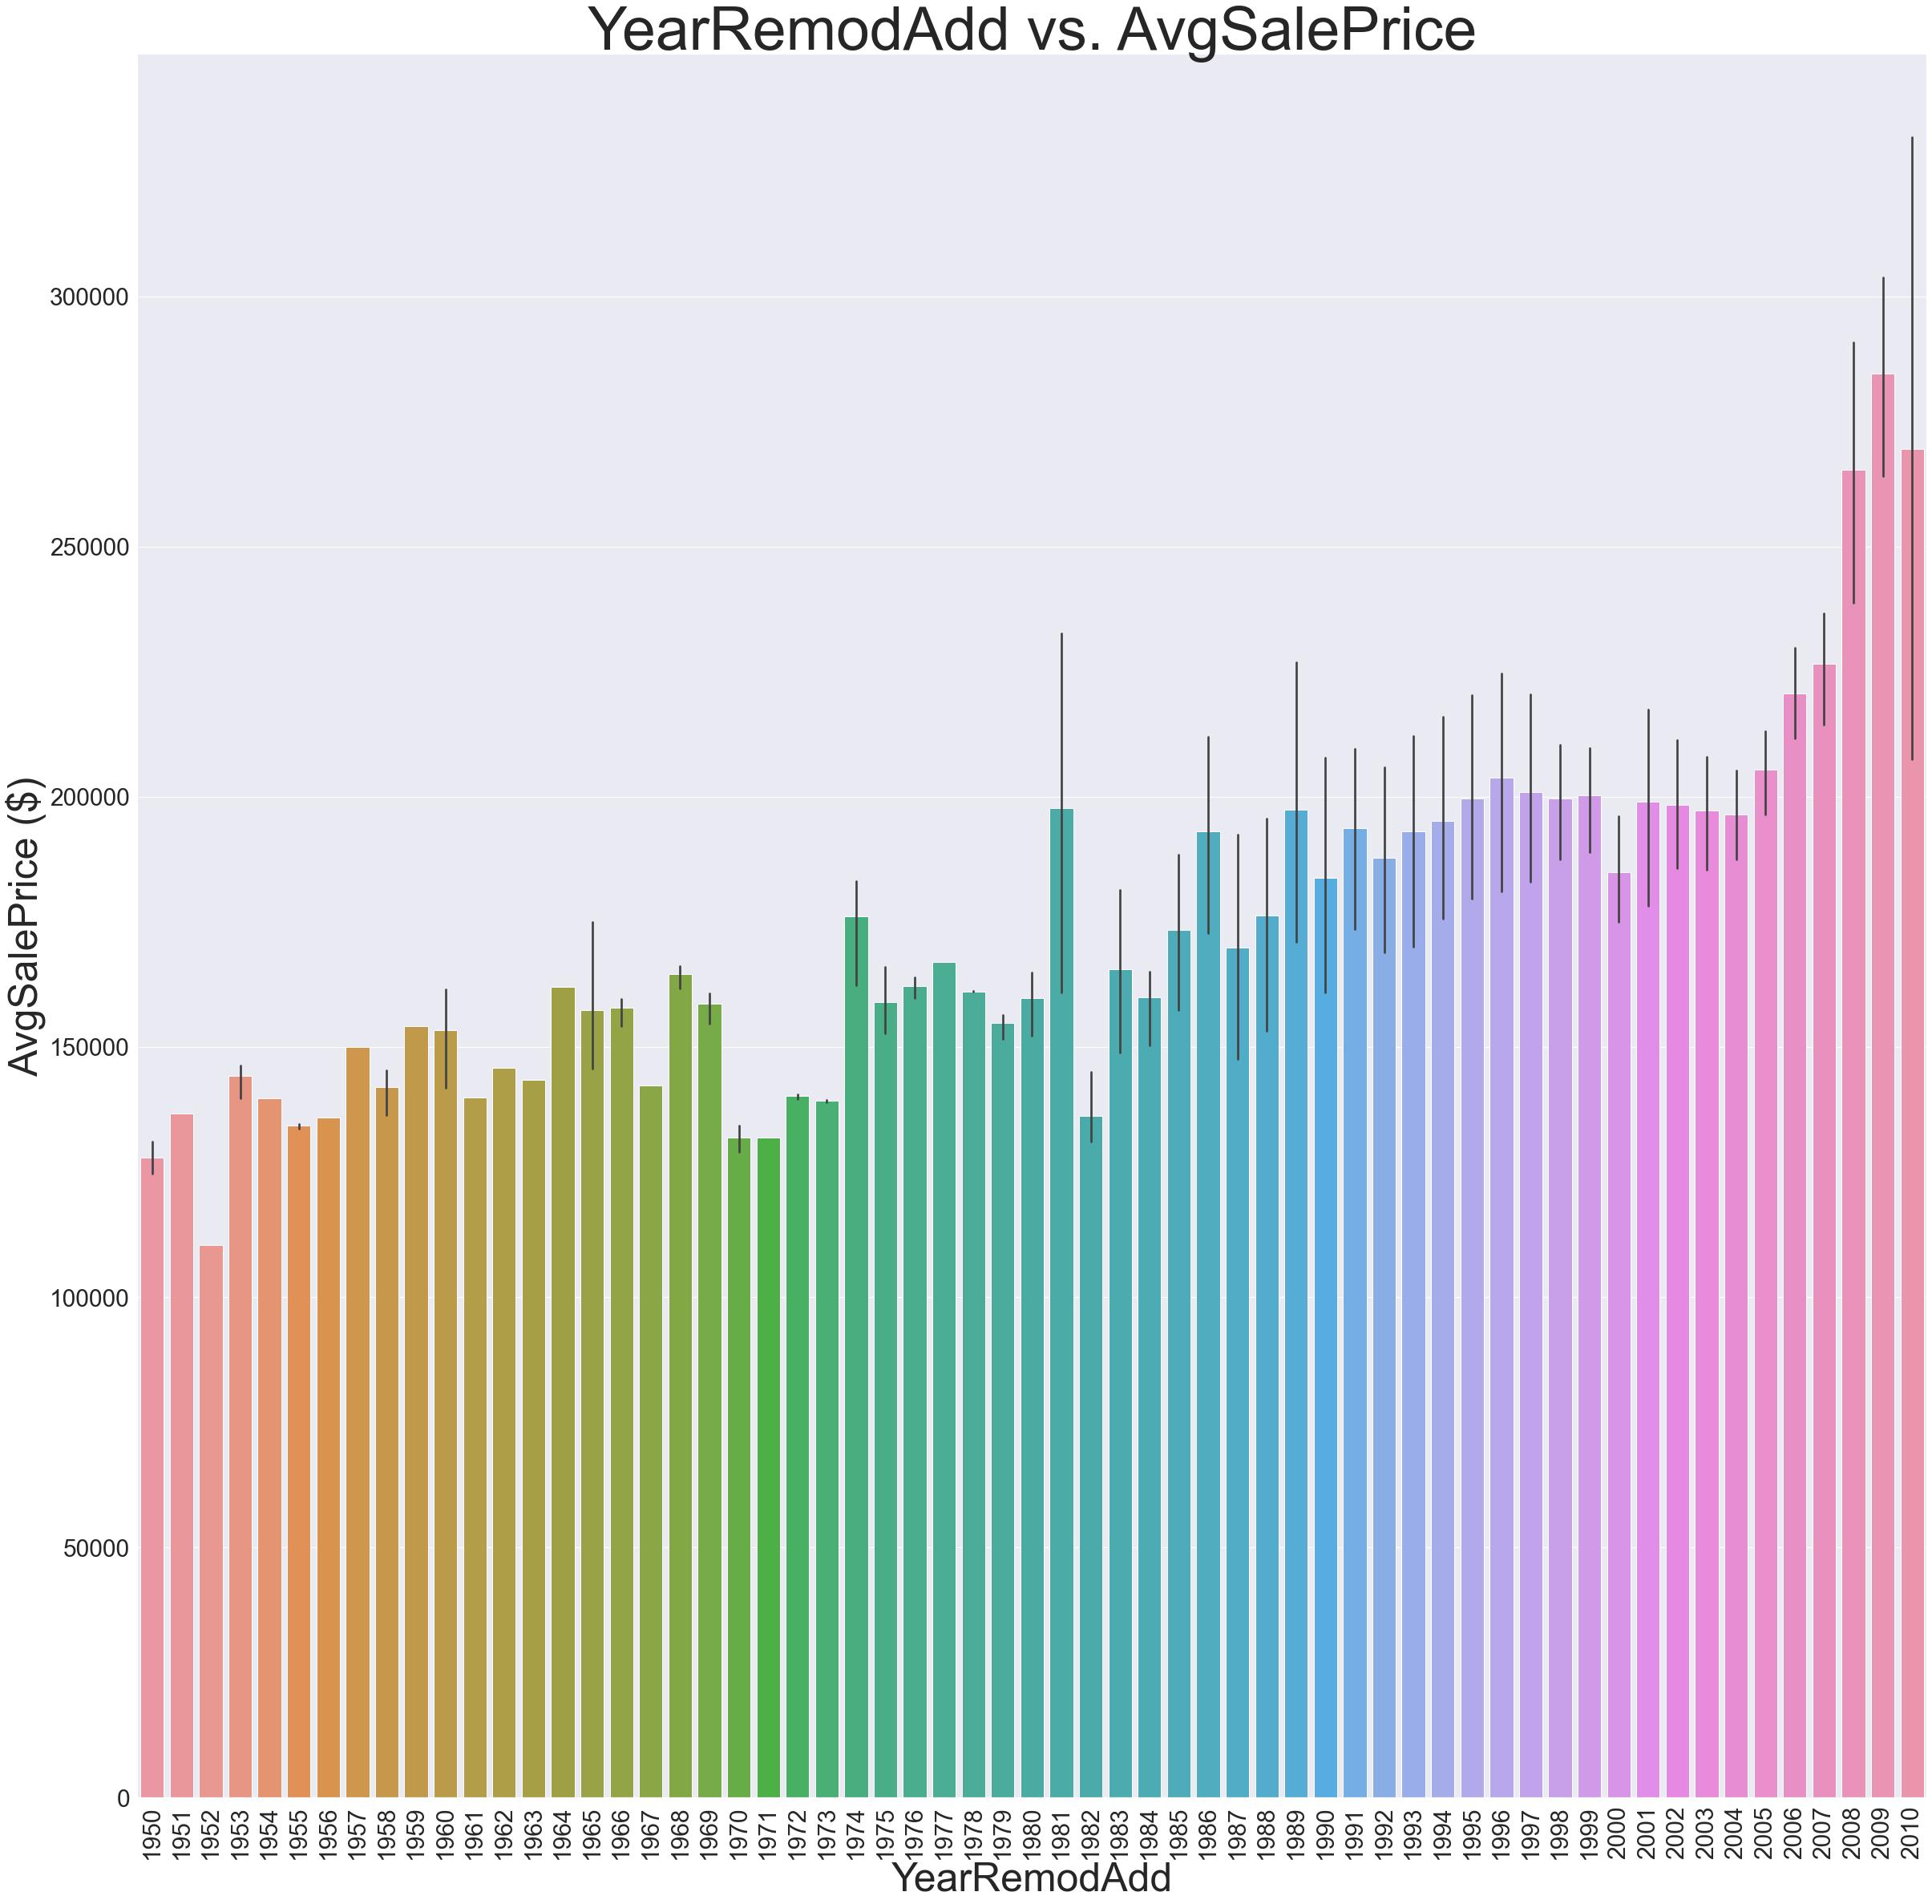

In [10]:
# Plot YearRemodAdd vs. AvgSalePrice
plt.rcParams['figure.figsize'] = 40,40
sns.set(font_scale=1.5)
g = sns.barplot(x='YearRemodAdd',y='AvgSalePrice',data=df)

g.axes.set_title("YearRemodAdd vs. AvgSalePrice",fontsize=75)
g.set_xlabel("YearRemodAdd",fontsize=50)
g.set_ylabel("AvgSalePrice ($)",fontsize=50)
g.tick_params(labelsize=30)
plt.xticks(rotation=90)

plt.savefig('AmesIA_YearRemodAdd_vs_AvgSalePrice')

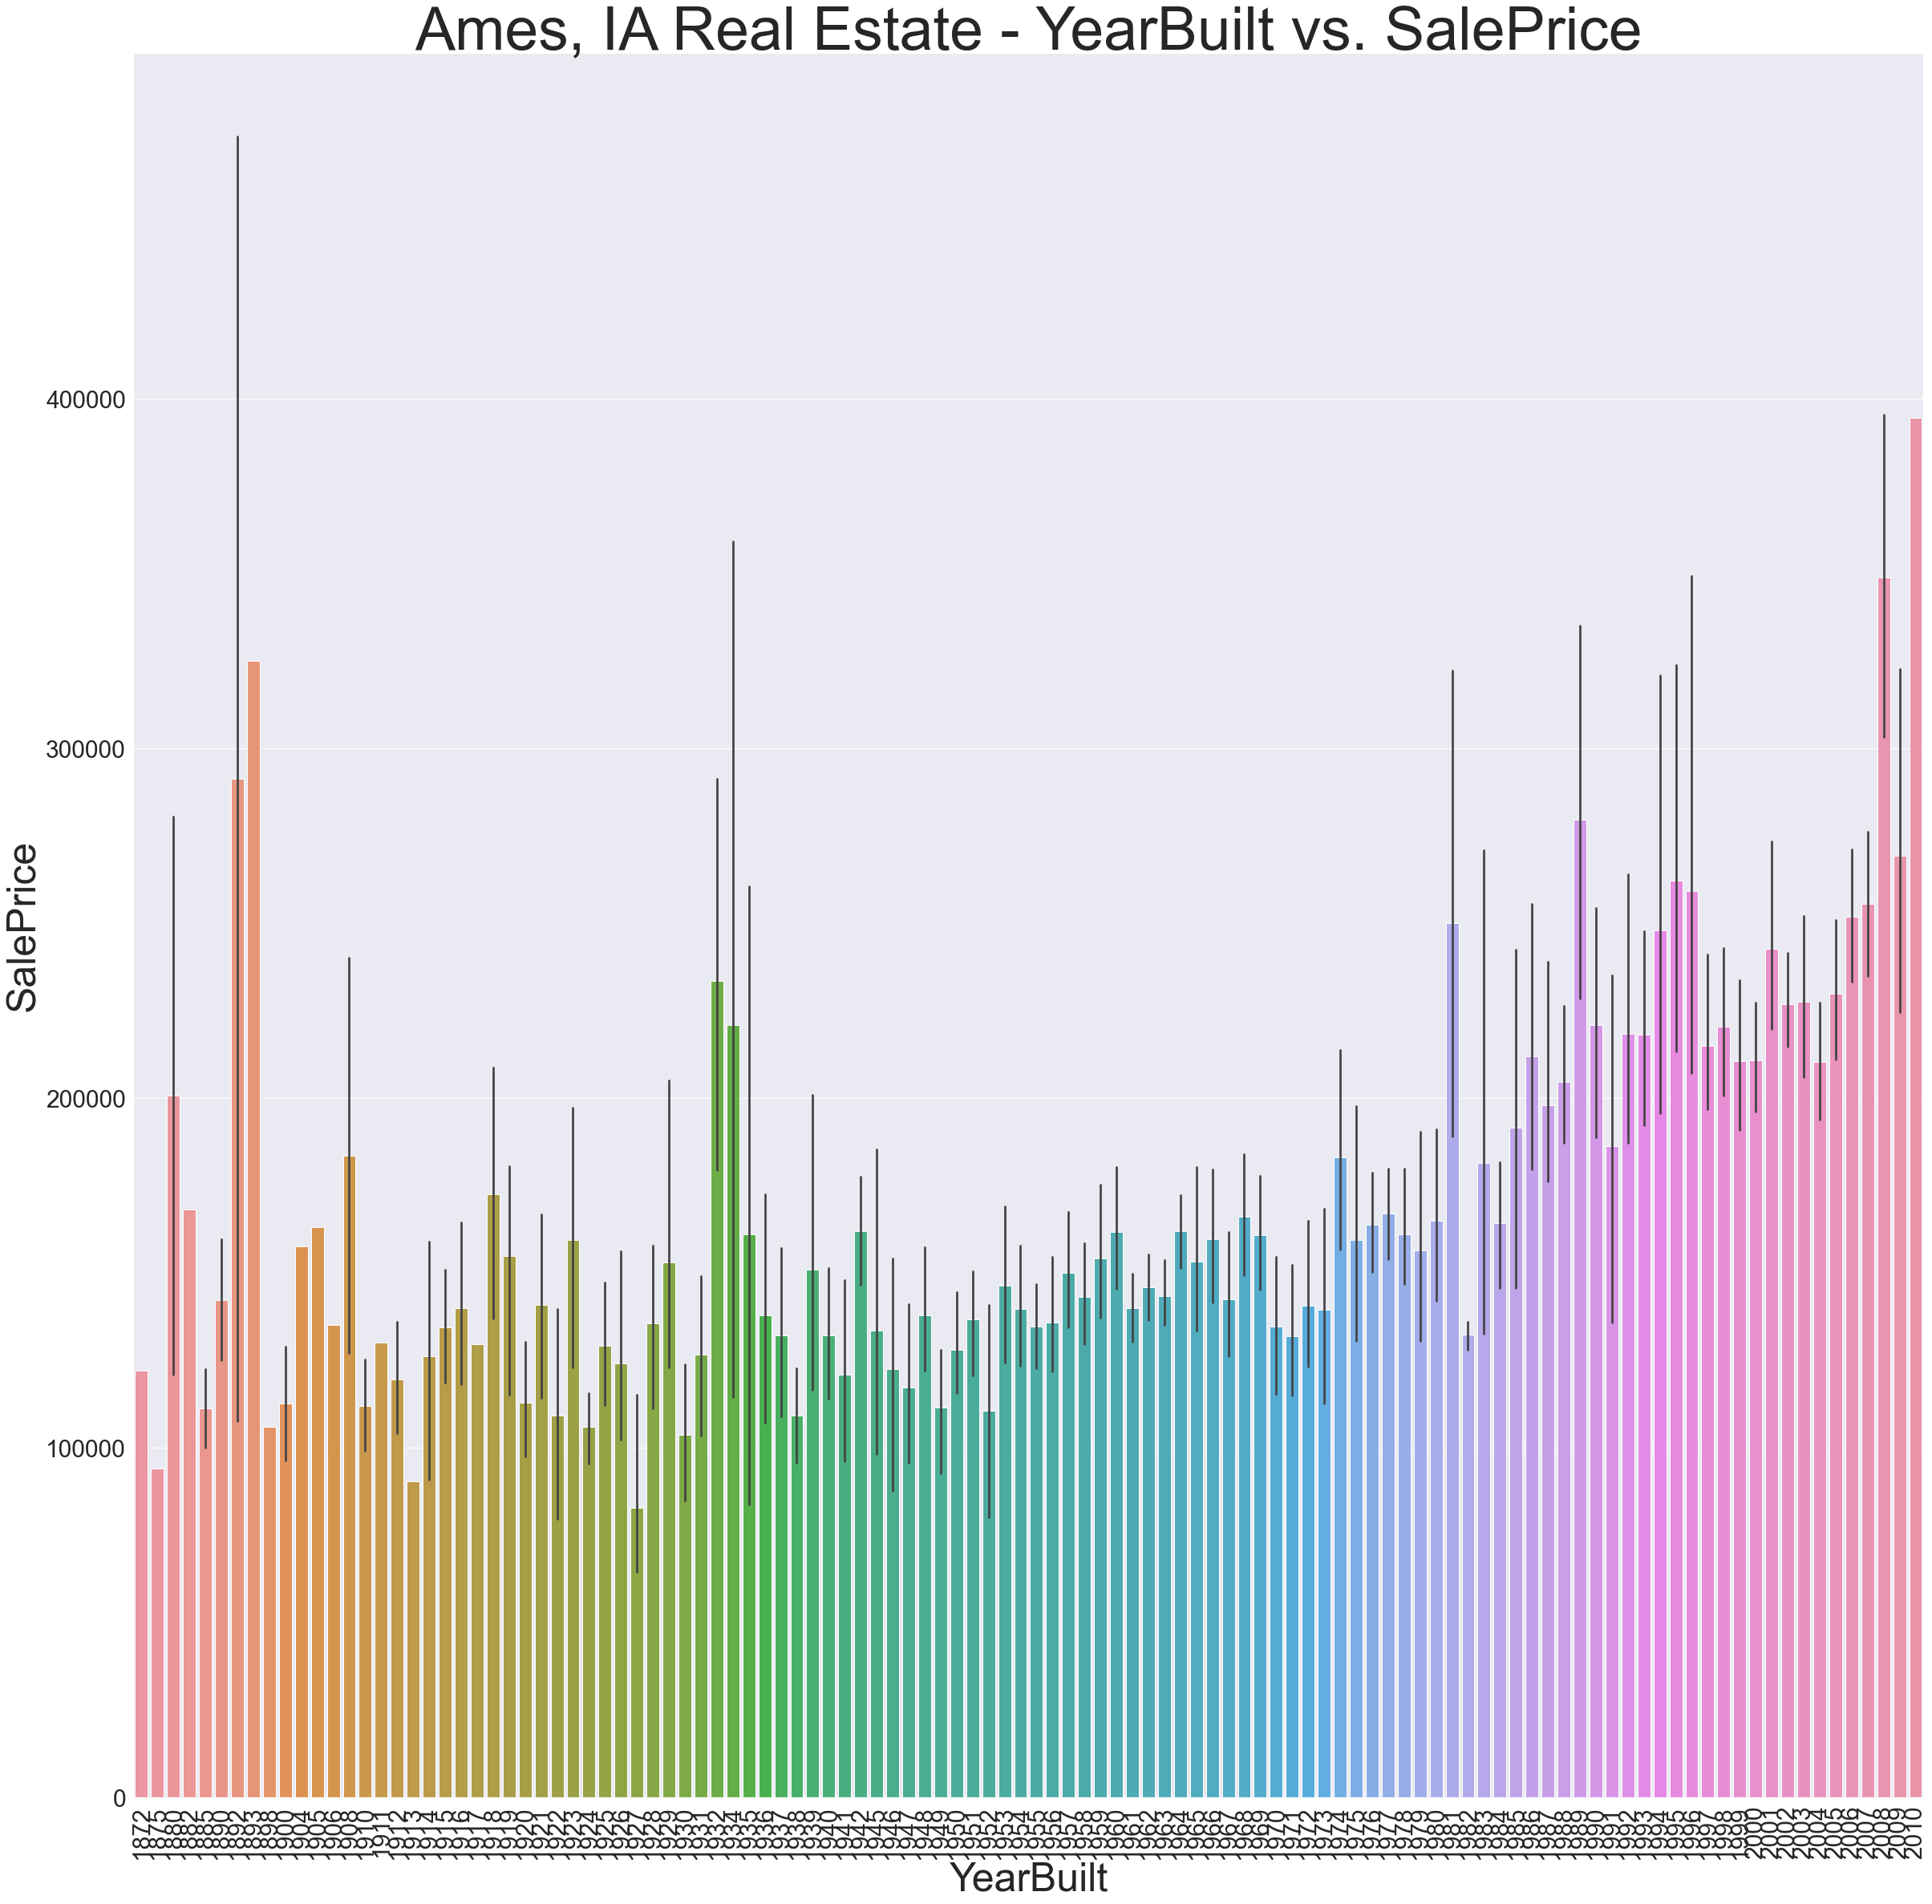

In [11]:
# Plot YearBuilt vs. SalePrice
plt.rcParams['figure.figsize'] = 40,40
sns.set(font_scale=1.5)

g = sns.barplot(x='YearBuilt',y='SalePrice',data=df)
g.axes.set_title("Ames, IA Real Estate - YearBuilt vs. SalePrice",fontsize=75)
g.set_xlabel("YearBuilt",fontsize=50)
g.set_ylabel("SalePrice",fontsize=50)
g.tick_params(labelsize=30)
plt.xticks(rotation=90)

plt.savefig('AmesIA_RealEstate_YearBuilt_vs_SalePrice')

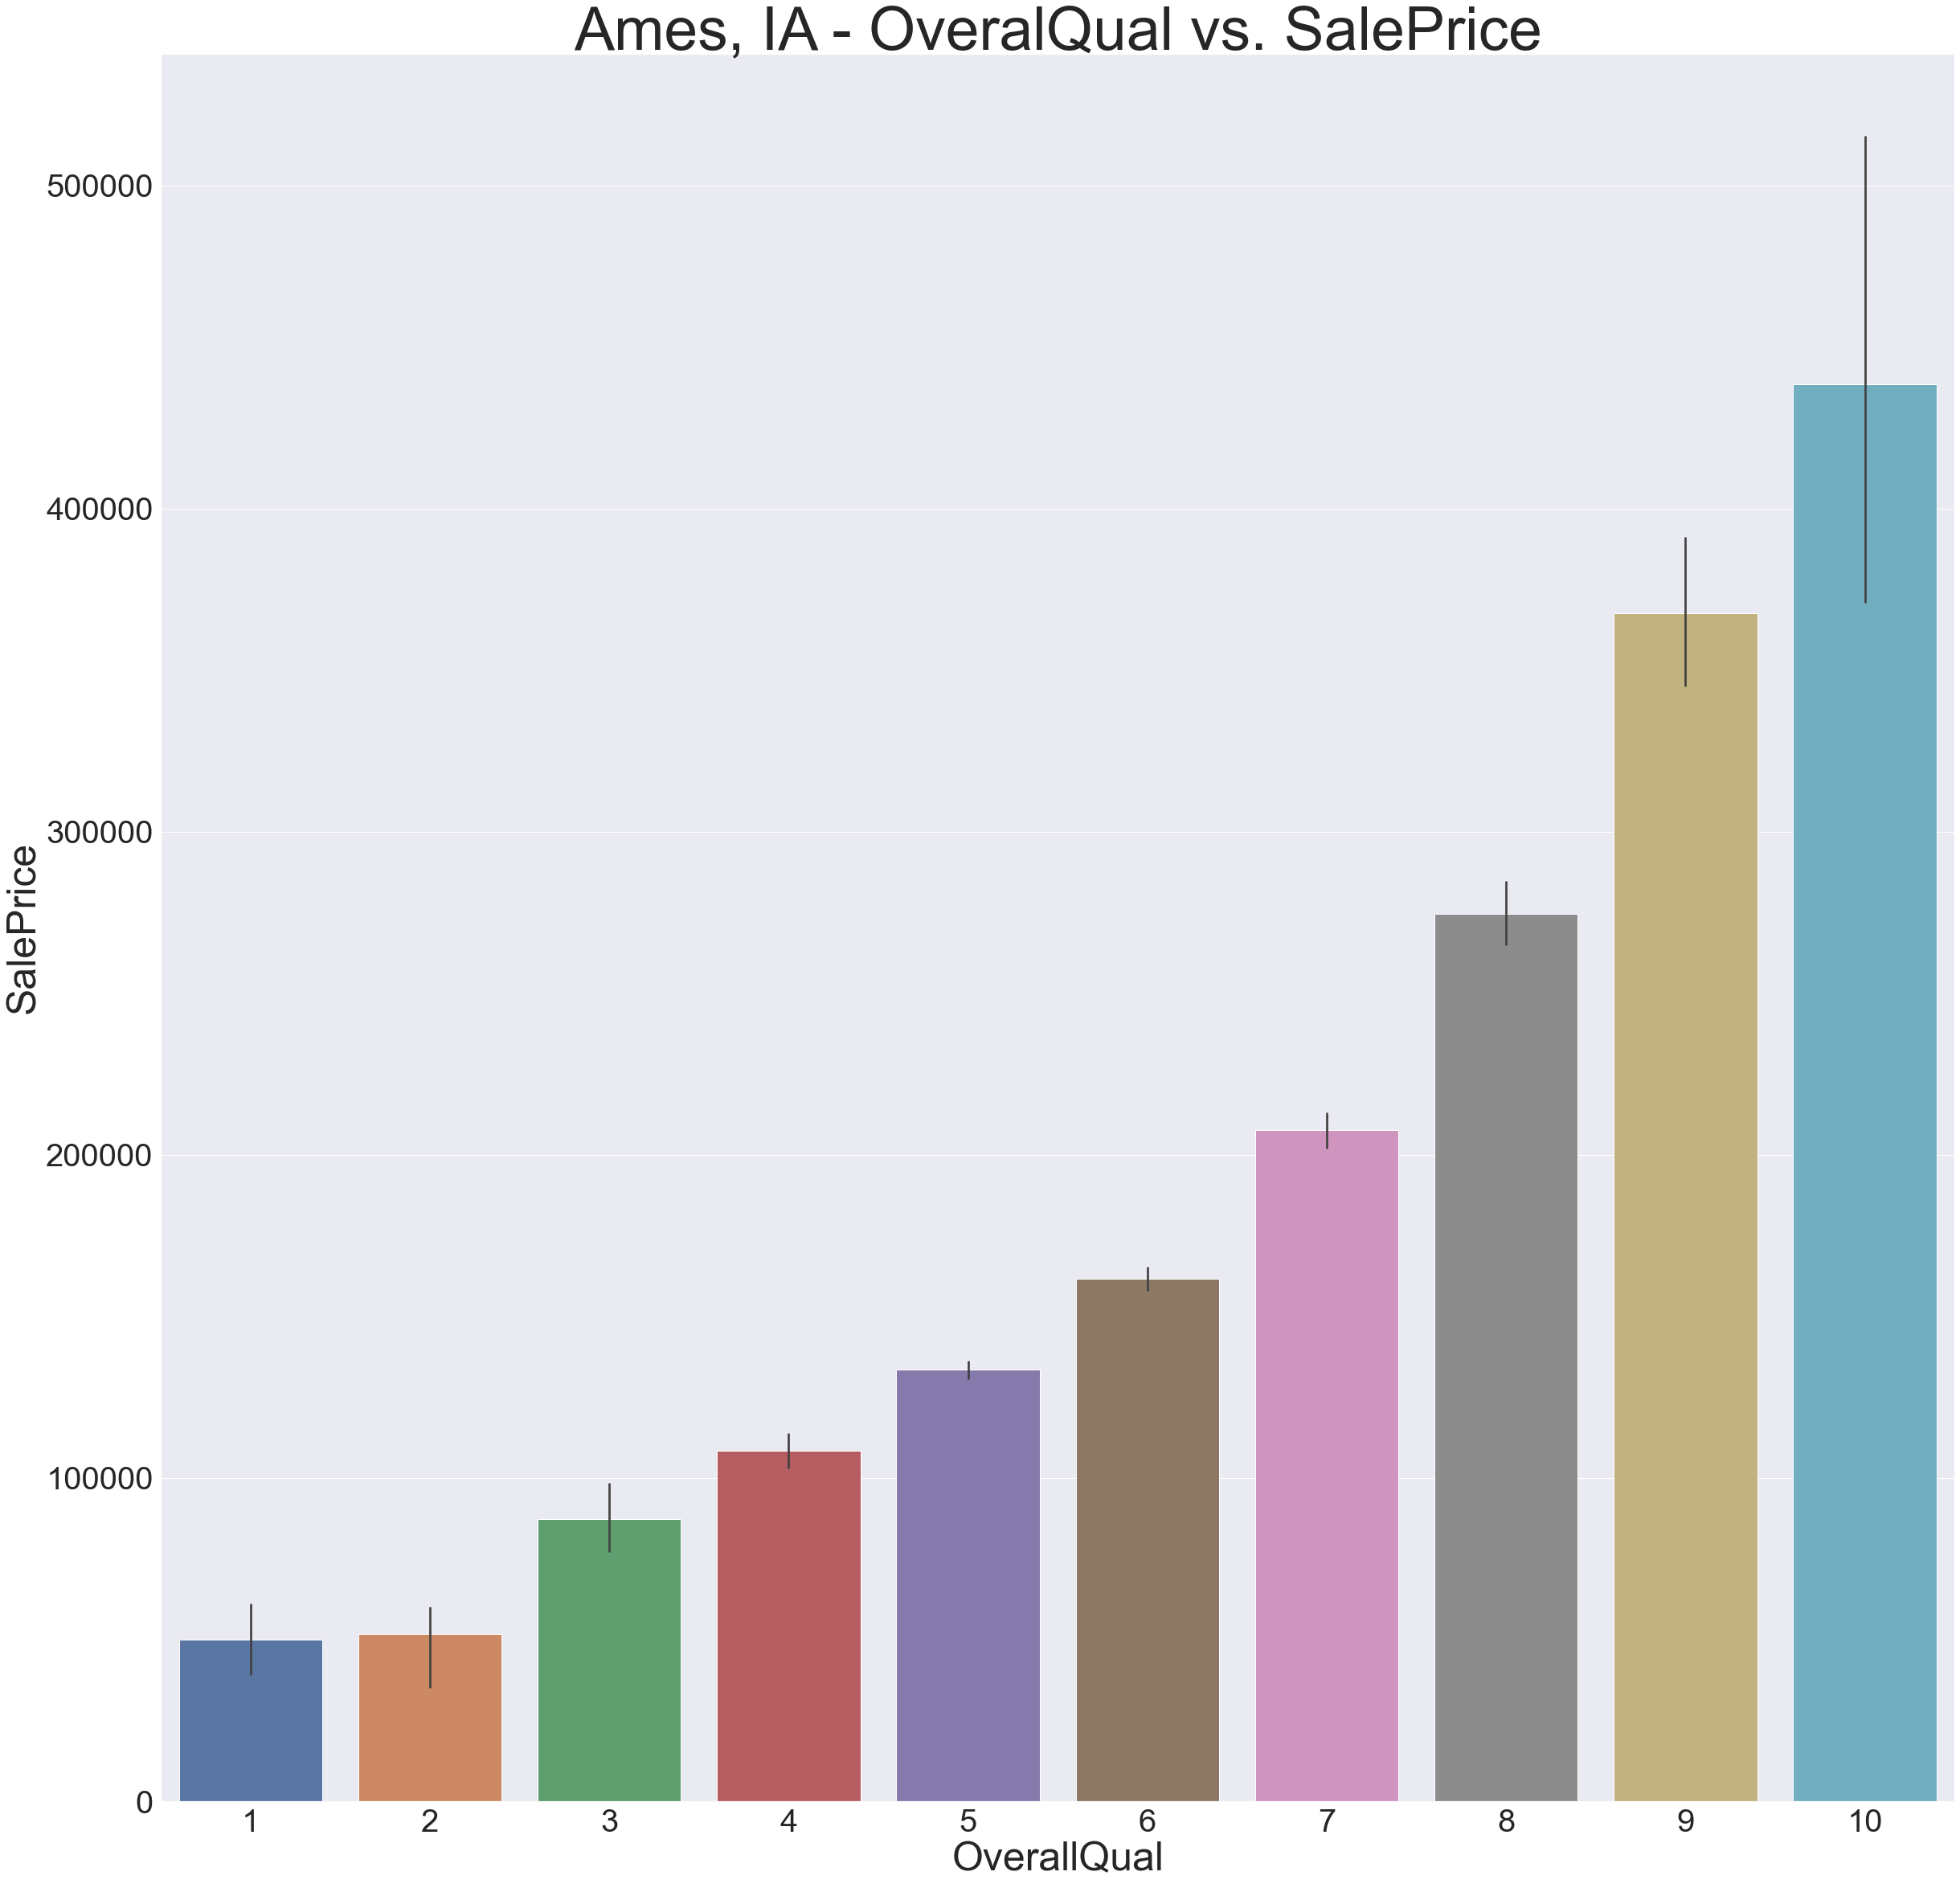

In [12]:
# Plot OverallQual vs. SalePrice
plt.rcParams['figure.figsize'] = 40,40
sns.set(font_scale=1.5)

g = sns.barplot(x='OverallQual',y='SalePrice',data=df)
g.axes.set_title("Ames, IA - OveralQual vs. SalePrice",fontsize=75)
g.set_xlabel("OverallQual",fontsize=50)
g.set_ylabel("SalePrice",fontsize=50)
g.tick_params(labelsize=40)
plt.xticks(rotation=0)

plt.savefig('AmesIA_RealEstate_OveralQual_vs_SalePrice')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

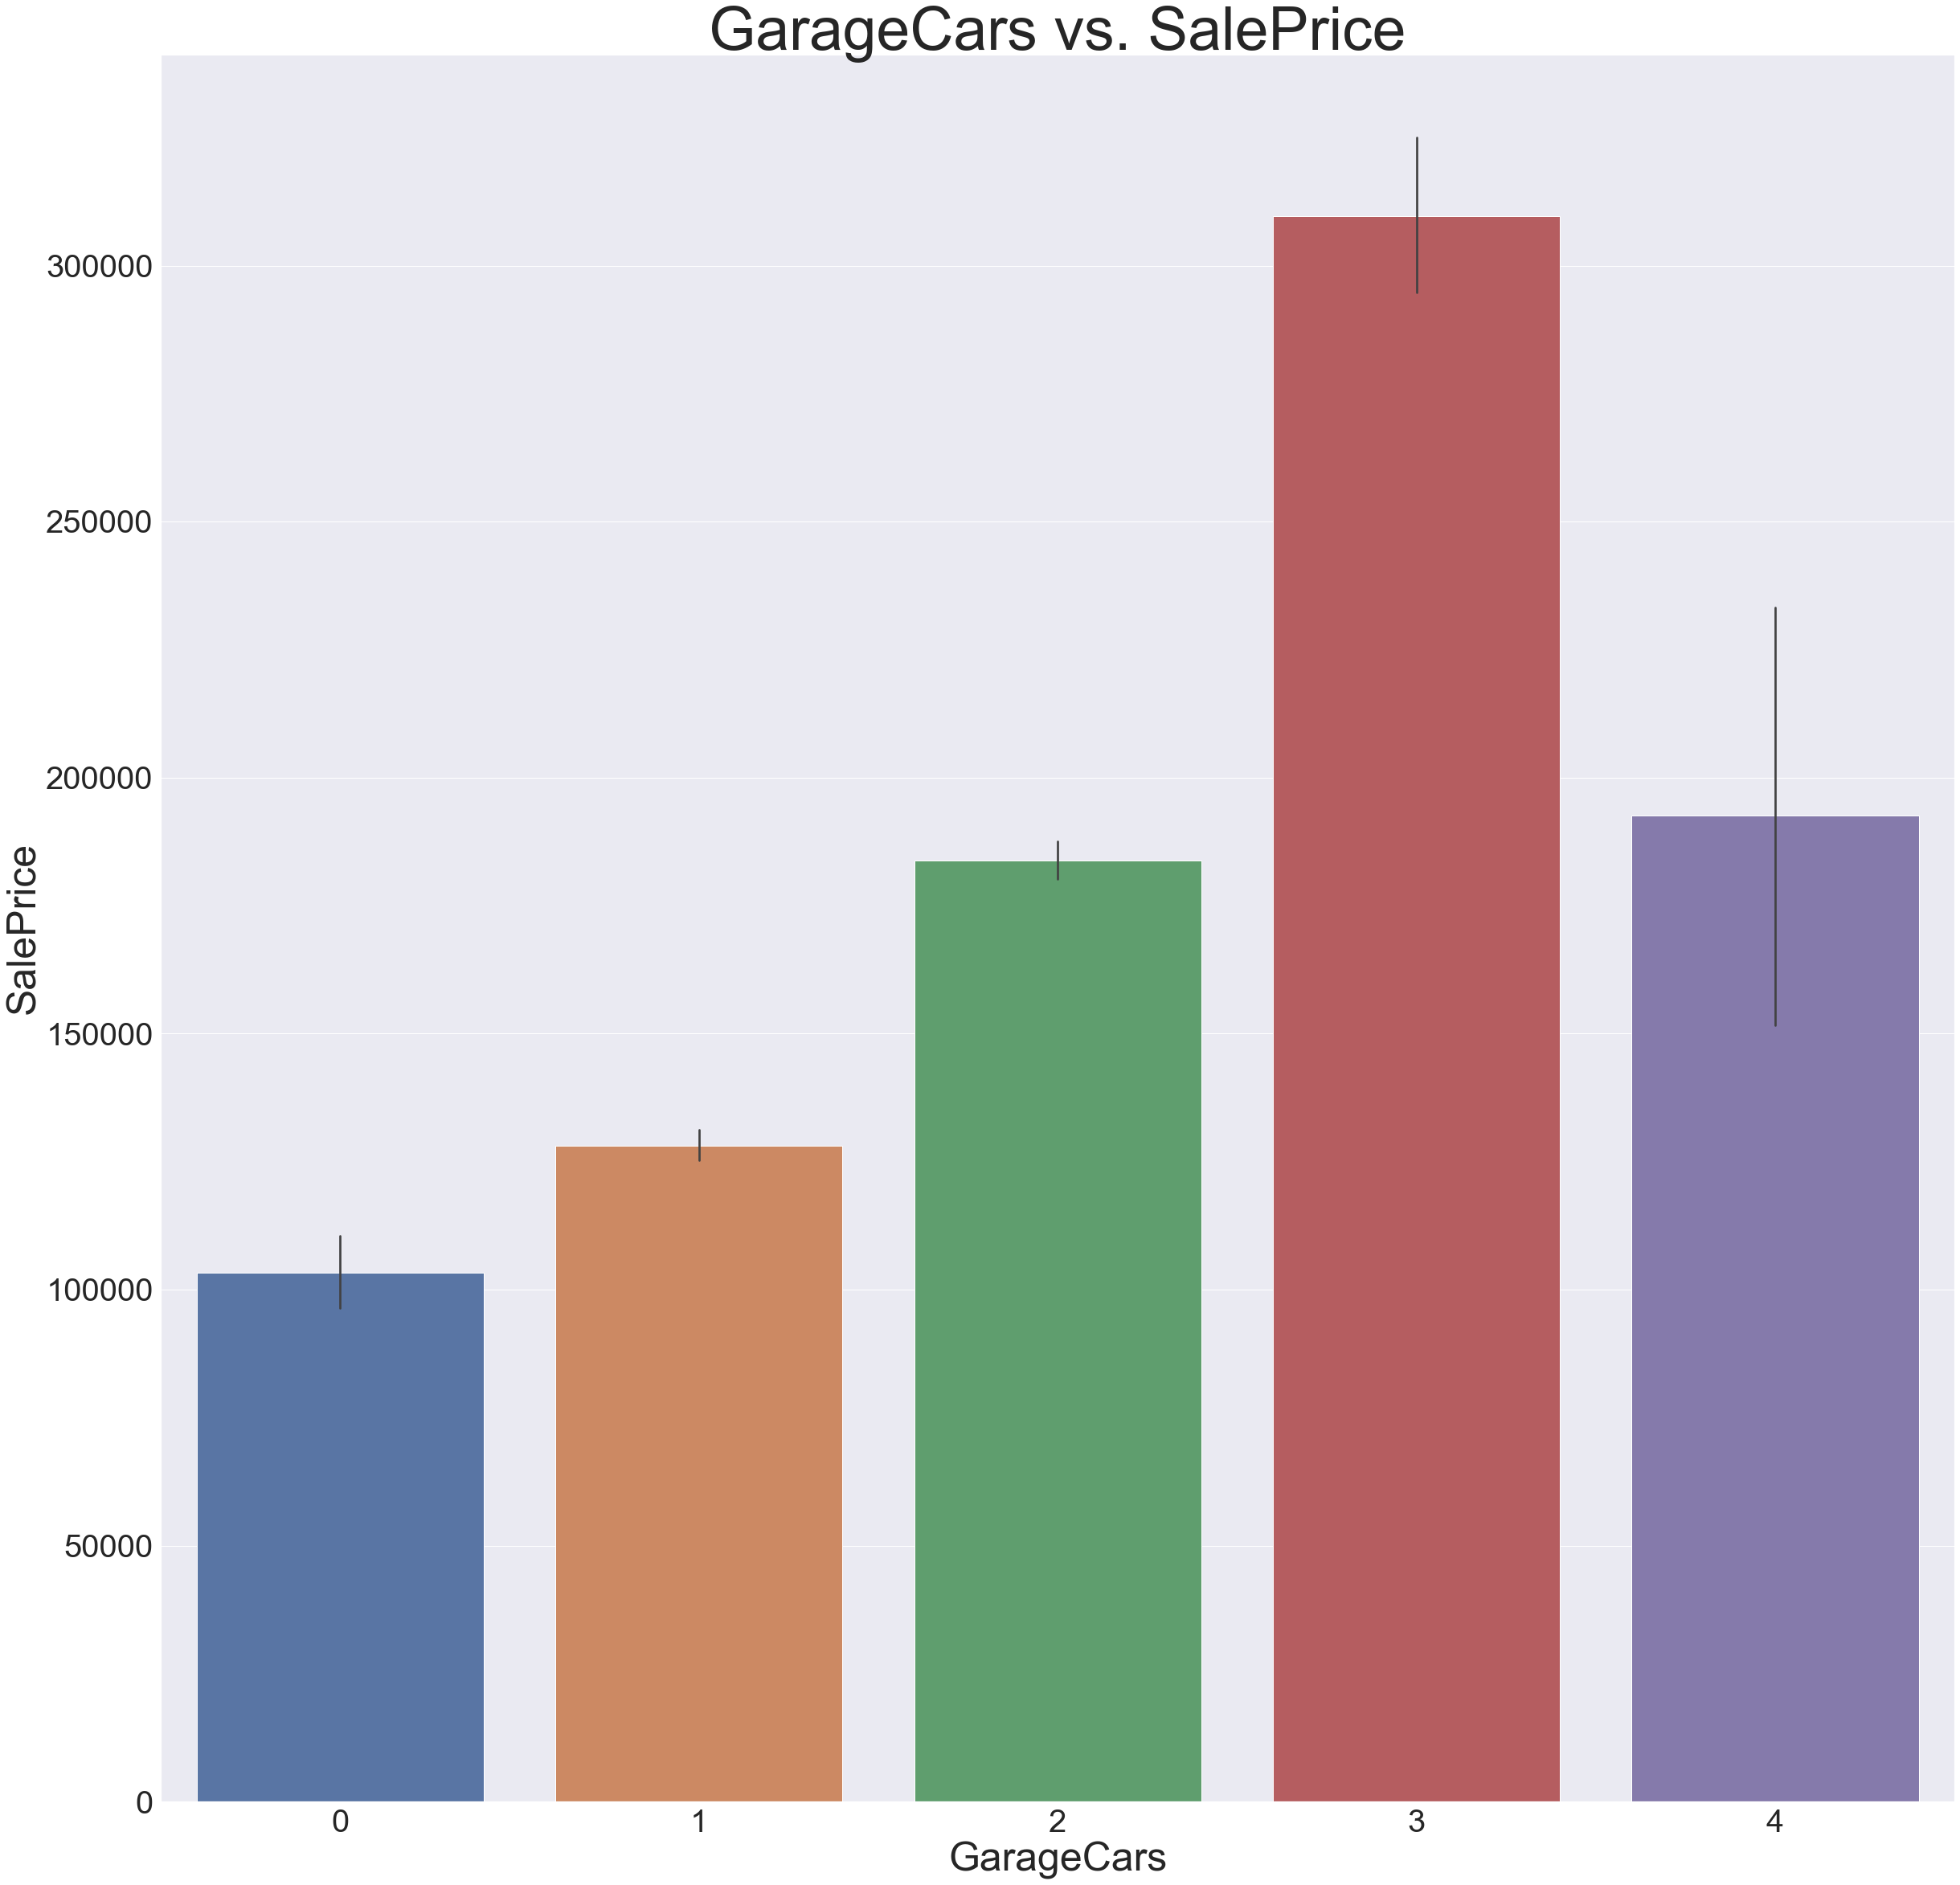

In [13]:
# Plot GarageCars vs. SalePrice 
plt.rcParams['figure.figsize'] = 40,40
sns.set(font_scale=1.5)

g = sns.barplot(x='GarageCars', y='SalePrice', data=df)
g.axes.set_title("GarageCars vs. SalePrice",fontsize=75)
g.set_xlabel("GarageCars",fontsize=50)
g.set_ylabel("SalePrice",fontsize=50)
g.tick_params(labelsize=40)
plt.xticks(rotation=0)

In [14]:
# Plot YearRemodAdd vs. AvgSalePrice Plotly
fig = px.bar(df, x='YearRemodAdd', y='AvgSalePrice',
             hover_data=['YearBuilt','YearRemodAdd', 'SalePrice','AvgSalePrice', 'Neighborhood'], 
             color='YearRemodAdd',
             title='Ames, IA Real Estate - YearRemodAdd vs. AvgSalePrice')
fig.write_html('YearRemodAdd vs. AvgSalePrice.html', include_plotlyjs='cdn')
fig.show()

## Plotly bar charts and summary statistics charts for attributes

In [15]:
# Create Plotly summary statistics interctive chart
import plotly.io as pio

x = df['YearRemodAdd']
y = df['SalePrice']

aggs = ["count","sum","avg","median","mode","rms","stddev","min","max","first","last"]

agg = []
agg_func = []
for i in range(0, len(aggs)):
    agg = dict(
        args=['transforms[0].aggregations[0].func', aggs[i]],
        label=aggs[i],
        method='restyle'
    )
    agg_func.append(agg)


data = [dict(
  type = 'bar',
  x = x,
  y = y,
  mode = 'markers',
  transforms = [dict(
    type = 'aggregate',
    groups = x,
    aggregations = [dict(
        target = 'y', func = 'sum', enabled = True)
    ]
  )]
)]

layout = dict(
  title = '<b>Plotly Aggregations</b><br>use dropdown to change aggregation',
  xaxis = dict(title = 'YearRemodAdd'),
  yaxis = dict(title = 'SalePrice', range = len(df)),
  updatemenus = [dict(
        x = 0.85,
        y = 1.15,
        xref = 'paper',
        yref = 'paper',
        yanchor = 'top',
        active = 1,
        showactive = False,
        buttons = agg_func
  )]
)

fig_dict = dict(data=data, layout=layout)

pio.show(fig_dict, validate=False)

In [16]:
fig = px.bar(df, x='OverallQual', y='SalePrice',
             hover_data=['OverallQual', 'SalePrice', 'AvgSalePrice', 'Neighborhood'], 
             color='OverallQual',
             title='Ames, IA Real Estate - OverallQual vs. SalePrice')
fig.write_html('OverallQual vs. AvgSalePrice.html', include_plotlyjs='cdn')
fig.show()

## Investigate outlier properties

- Combine 1st and 2nd floor square footage and created TotalSF column

In [17]:
# Combine 1st, 2nd and finished basement sqft together (1stFlrSF, 2ndFlrSF)
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + 

SyntaxError: invalid syntax (1519808317.py, line 2)

In [ ]:
fig_hist = px.histogram(df, x='TotalSF', title='Real Estate Histogram - TotalSF',
                         marginal="box", # can be `box`, `violin`
                        histnorm='percent')
fig_hist.show()

In [ ]:
# Create TotalSF Histogram
plt.rcParams['figure.figsize'] = 20,20
sns.set(font_scale=1.5)

g = sns.histplot(data=df, x="TotalSF")
g.axes.set_title("Real Estate Histogram - TotalSF",fontsize=40)
g.set_xlabel("TotalSF",fontsize=20)
g.set_ylabel("Count",fontsize=20)
g.tick_params(labelsize=10)
plt.xticks(rotation=0)

In [ ]:
# drop the outlier homes with the top square footage (> 4600)
df = df.drop(df[df['TotalSF'] > 4600].index)

# Feature and Prediction Target Split

In [ ]:
features = [x for x in df.columns if x not in ['SalePrice']]
X = df[features]
y = df['SalePrice']

# Initial Preprocessing

In [ ]:
# Train the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Split the data up in to numerical data (int and float) and categorical 
# data (objects, names, words etc.)
num_cols = [cname for cname in X_train.columns 
            if X_train[cname].dtype in ['int64', 'float64', 'bool']]

category_cols = [cname for cname in X_train.columns 
                 if X_train[cname].nunique() < 13 and 
                 X_train[cname].dtype == "object"]

# SimpleImputer is a function that replaces null cell values with the mean,
# median, most frequent or a fixed value based on the dataset used
numerical_transformer = SimpleImputer(strategy='constant')

# The same process can be applied to categorical values (strings, objects, etc.)
# and automated using the Pipeline function
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transform all data in columns using the preprocessor and ColumnTransformer function
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, category_cols)
])



# Model Selection

 Decision Tree, Random Forest and XGBoost models will be used to analyze the dataset and predict housing prices. The model with the lowest RMSLE (Root Mean Squared Log Error) will be selected

# Model I: Decision Tree Test

In [ ]:


# Import model from sklearn
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)

# Setup a Pipeline processing function
tree_clf = Pipeline(steps=[('preprocessor',preprocessor),
                          ('tree_model',tree_model)])

# Fit the training dataset to the model
tree_clf.fit(X_train,y_train)

# Set tree_preds to the test feature data (X_test)
tree_preds = tree_clf.predict(X_test)

# Print the RMSLE results
print('RMSLE:', root_mean_squared_log_error(y_test,tree_preds))

# Model II: Random Forest Test

In [ ]:


from sklearn.ensemble import RandomForestRegressor

rand_model = RandomForestRegressor(random_state=42)

rand_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rand_model', rand_model)
                     ])
# Fit the training data to the model
rand_clf.fit(X_train, y_train)

rand_preds = rand_clf.predict(X_test)

print('RMSLE:', root_mean_squared_log_error(y_test, rand_preds))

# Model III: XGBoost Test

In [ ]:


xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.02, objective='reg:squarederror', random_state=42)

xgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb_model', xgb_model)
                     ])

xgb_clf.fit(X_train, y_train, xgb_model__verbose=False)

xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)

print('RMSLE:', root_mean_squared_log_error(y_test, xgb_preds))

The XGBoost model performed the best out of the three models with a score of 0.128!

The XGBoost model can be improved further by tuning the parameters of the model. 

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


grid = GridSearchCV(xgb_model,param_grid=params,n_jobs=4,cv=5,verbose=3)
                    
grid.fit(X_train, y_train)
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)

In [ ]:
hp_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

hp_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('hp_model', hp_model)
                     ])

hp_clf.fit(X_train, y_train, hp_model__verbose=False)

hp_preds = hp_clf.predict(X_test)

print('RMSLE:', root_mean_squared_log_error(y_test, hp_preds))

## Determine Feature Importance in XGB model

model = xgb_clf.named_steps['xgb_model']

feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (10,8)) ## plot top 20 features

## Display top 10 features for XGBoost model

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance

feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["SCORE"]).sort_values(by = "SCORE", ascending=False)
data['FEATURE_IMPORTANCE_KEY'] = data.index
data.reset_index(inplace=True,drop=True)

# The size of the beta coefficient for each Feature in the model affects the SalePrice by a certain amount
df_beta = pd.DataFrame(zip(X_train.columns, model.get_booster().get_score(importance_type='gain')), columns=['FEATURE','FEATURE_IMPORTANCE_KEY'])

df_feat = pd.merge(df_beta, data, on='FEATURE_IMPORTANCE_KEY', how='inner')
df_feat = df_feat.sort_values(by='FEATURE_IMPORTANCE_KEY',ascending=False).reset_index(drop=True)
df_feat['FEATURE_IMPORTANCE_KEY'] = df_feat['FEATURE_IMPORTANCE_KEY'].str.replace('f','')
df_feat['FEATURE_IMPORTANCE_KEY'] = df_feat['FEATURE_IMPORTANCE_KEY'].astype('int32')
df_feat['SCORE'] = df_feat['SCORE']  / 10**6
df_feat = df_feat.sort_values(by='SCORE',ascending=False).reset_index(drop=True)
df_feat = df_feat.head(10)

# Display top 10 features for XGBoost model
fig = px.bar(df_feat,
             x='SCORE',
             y='FEATURE',
             hover_data=['FEATURE',
                        'SCORE'],
            title='XGBoost Regression Model: Feature Importance Score - Importance Type = Gain')
fig.show()

# Final model Setup

Feature Engineering

In [ ]:
X.columns.to_list()

In [ ]:
print(set(X['SaleCondition']))

In [ ]:
print(X['YearBuilt'].head())
print('\n')
print(X['YearRemodAdd'].head())

In [ ]:
print(set(X['YrSold']))
print('\n')
print(set(X['MoSold']))

In [ ]:
print(set(X['ExterQual']))
print(set(X['ExterCond']))

In [ ]:
print(set(X['YearBuilt']))
print('\n')
print(set(X['OverallQual']))

In [ ]:
print(set(X['BedroomAbvGr']))
print(set(X['FullBath']))
print(set(X['HalfBath']))

Based on the features in the columns, a few things stand out:
    
  - Subtracting YearBuilt from YearRemodAdd determines how recentrenovation was
    completed (adds value to the house).
  - Lot geometry can be determined by dividing LotArea by LotFrontage. If the       lot is a good shape, it'll sell better. If it's strange than it may be less
    likely to sell.
  - Location in Ames? Is their high crime in the area? What is the income          level     in the neighborhood? Is it inner-city with a black or white          population? Is     it close to the downtown area or accessible to              shopping/university/transit/major road networks?
   
  - Features to combine:
       - YrSold and MoSold
       - Condition1 and Condition2
       - ExterQual and ExterCont
       - YearBuilt and OverallQual
       - Is their a finished basement?
       - Finished basement sqft
       
    

In [ ]:
# Make a copy of the features (X values)
X_feat_eng = X.copy()

In [ ]:
# Create the combined features
X_feat_eng['YearsSinceReno'] = X_feat_eng['YearRemodAdd'] - X_feat_eng['YearBuilt']
X_feat_eng['LotShape'] = X_feat_eng['LotArea'] / X_feat_eng['LotFrontage']
X_feat_eng['LandTopo'] = X_feat_eng['LandSlope'] + '_' + X_feat_eng['LandContour']
X_feat_eng['ValueRating'] = X_feat_eng['YearBuilt'] * X_feat_eng['OverallQual']
X_feat_eng['FinishedBsmt'] = X_feat_eng['BsmtFinSF1'] > 0
X_feat_eng['GarageVal'] = X_feat_eng['YearBuilt'] * X_feat_eng['GarageCars']
X_feat_eng['MiscVal'] = X_feat_eng['Fireplaces'] + X_feat_eng['OverallQual']  
X_feat_eng = X_feat_eng.drop(columns=['GarageCars'])


In [ ]:
# Split the data up in to numerical data (int and float) and categorical 
# data (objects, names, words etc.)
feat_num_cols = [cname for cname in X_feat_eng.columns 
            if X_feat_eng[cname].dtype in ['int64', 'float64']]

feat_category_cols = [cname for cname in X_feat_eng.columns 
                 if X_feat_eng[cname].nunique() < 100 and 
                 X_feat_eng[cname].dtype in ['object', 'bool']]

# SimpleImputer is a function that replaces null cell values with the mean,
# median, most frequent or a fixed value based on the dataset used
feat_numerical_transformer = SimpleImputer(strategy='constant')

# The same process can be applied to categorical values (strings, objects, etc.)
# and automated using the Pipeline function
feat_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transform all data in columns using the preprocessor and ColumnTransformer function
feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', feat_numerical_transformer, feat_num_cols),
        ('cat', feat_categorical_transformer, feat_category_cols)
])


In [ ]:
feature_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=0.0, monotone_constraints='()',
             n_estimators=1250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

feature_clf = Pipeline(steps=[('feature_preprocessor', feature_preprocessor),
                      ('feature_model', feature_model)
                     ])

feature_X_train, feature_X_valid, feature_y_train, feature_y_valid = train_test_split(X_feat_eng, y, random_state=0)

feature_clf.fit(feature_X_train, feature_y_train, feature_model__verbose=False) 
feature_preds = feature_clf.predict(feature_X_valid)

print('RMSLE:', root_mean_squared_log_error(feature_y_valid, feature_preds))

In [ ]:
model = feature_clf.named_steps['feature_model']

feats = {} # a dict to hold feature_name: feature_importance

feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["SCORE"]).sort_values(by = "SCORE", ascending=False)
data['FEATURE_IMPORTANCE_KEY'] = data.index
data.reset_index(inplace=True,drop=True)

# The size of the beta coefficient for each Feature in the model affects the SalePrice by a certain amount
df_beta = pd.DataFrame(zip(X_train.columns, model.get_booster().get_score(importance_type='gain')), columns=['FEATURE','FEATURE_IMPORTANCE_KEY'])

df_feat = pd.merge(df_beta, data, on='FEATURE_IMPORTANCE_KEY', how='inner')
df_feat = df_feat.sort_values(by='FEATURE_IMPORTANCE_KEY',ascending=True).reset_index(drop=True)
df_feat['FEATURE_IMPORTANCE_KEY'] = df_feat['FEATURE_IMPORTANCE_KEY'].str.replace('f','')
df_feat['FEATURE_IMPORTANCE_KEY'] = df_feat['FEATURE_IMPORTANCE_KEY'].astype('int32')
df_feat['SCORE'] = df_feat['SCORE'] / 10**6
df_feat = df_feat.sort_values(by='SCORE',ascending=False).reset_index(drop=True)
df_feat = df_feat.head(10)

# Display top 10 features for XGBoost model
fig = px.bar(df_feat,
             x='SCORE',
             y='FEATURE',
             hover_data=['FEATURE',
                        'SCORE'],
            title='XGBoost Final Regression Model: Feature Importance Score - Importance Type = Gain')

fig.show()